In [1]:
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils import data
#device = "cuda" 
device = "cpu" 

class LWR_batch_version(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, tskip, plm = True, plm_vf = True, initial='random', boundary='zeros',
                fix_vf=False, parstep=1): 
        super(LWR_batch_version, self).__init__()
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = [] 
        self.tskip = tskip 
#         self.y_max = y_max 
#         self.y_min = y_min 
        self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        
        self.initial = {} # shape: [batch, 3, # sensors]
        self.boundary = {} # shape: [batch, seq_len, 3]
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        self.flag = plm 
        
        # use piecewise linear function for kj
        if plm == False: 
            self.kappa = torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
#             print(self.kappa, self.kappa.shape)
        else: 
            self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx).to(device)
        
        #characteristic velocity vf
        if not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
#             self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx, x = vf)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, xi, initial, boundary, tsteps): 
        self.xi = xi 
        nt=tsteps 
        self.initial = torch.nn.Parameter(initial).to(device)
        self.boundary = torch.nn.Parameter(boundary).to(device)

        batch_size = self.initial.shape[0]
       
        self.k = [self.initial[:, 0]]
        self.q = [self.initial[:, 1]]
        self.u = [self.initial[:, 2]]
        
        #initial values at output points
        self.ki=[self.initial[:, 0][:, self.xi[0]]]
        self.ui=[self.initial[:, 1][:, self.xi[0]]]
        self.qi=[self.initial[:, 2][:, self.xi[0]]]
#         print("k", self.k[0].shape)
        for n in range(1, nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            nu=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            nq=torch.zeros((batch_size, nx), requires_grad=True).double().to(device)
            
            #new values for 3 variables stored in one tensor per time step
            nk[:, 0] = self.boundary[:, 0, n]
            nq[:, 0] = self.boundary[:, 1, n]
            nu[:, 0] = self.boundary[:, 2, n] 
            
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
            if self.flag: 
                hkappa = kappa[:, n - 1]
            else: 
                hkappa=self.kappa[idx.long()]
            hvf=self.vf[idx.long()] #.repeat(batch_size, 1)

            nk[:, 1:] = self.k[n-1][:, 1:] - 0.0016 * self.dt / self.dx * (self.q[n-1][:, 1:]-self.q[n-1][:, :-1]) 
#             idx = nk < 0. 
#             nk[idx] = 0.01 
            nu[:, 1:] = hvf[1:] * (1 - nk[:, 1:] / hkappa[1:])
#             idx = nu < 0.
#             nu[idx] = 2  
            nq[:, 1:] = nk[:, 1:] * nu[:, 1:] 
#             idx = nq < 0.
#             nq[idx] = 0.2  
            


            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq) 
            
            #only output every tskip timesteps
            if (n % self.tskip) == 0: 
                self.ki.append(nk[:, self.xi[0]])
                self.ui.append(nu[:, self.xi[0]])
                self.qi.append(nq[:, self.xi[0]])

        pred = torch.stack([torch.stack(self.ki, dim = 1),torch.stack(self.qi, dim = 1),torch.stack(self.ui, dim = 1)], dim = 1) 
        
        return pred[:, :, 1:, 1:] 

In [3]:
import torch

In [4]:
out=torch.load("../data/time_AutoODE1.pt")

In [5]:
out["preds"].shape

(10654, 3, 12, 77)

In [6]:
out["trues"].shape

(10654, 3, 12, 77)

In [7]:
out["model"].k[0].shape

torch.Size([414, 380])

In [8]:
out["model"].ki[-1].shape

torch.Size([414, 78])

In [9]:
import matplotlib.pyplot as plt

In [10]:
out["model"].xi.shape

torch.Size([414, 78])

In [11]:
dx=out["model"].dx.cpu().detach().numpy()
nx=out["model"].nx
xpos=np.linspace(0, (nx-1)*dx, nx)

In [12]:
xi=out["model"].xi.cpu().numpy()
xi.shape

(414, 78)

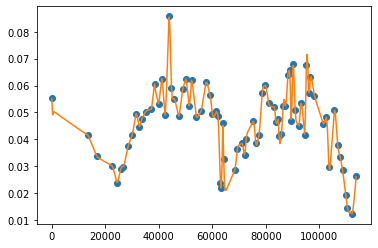

In [13]:
#batch id
bi=10
plt.plot(xpos[xi[bi,:]], out["model"].ki[-1][bi,:].cpu().detach(), linewidth=0,
        marker="o");
plt.plot(xpos, out["model"].k[-1][bi,:].cpu().detach());

In [14]:
out["model"].k[-1][0,:].max()

tensor(0.0909, device='cuda:0', dtype=torch.float64)

In [15]:
ksnap=out["model"].k[-1][bi,:].cpu().detach().numpy()
usnap=out["model"].u[-1][bi,:].cpu().detach().numpy()

In [16]:
np.save("k_snapshot_LWR.npy", ksnap)
np.save("u_snapshot_LWR.npy", usnap)
np.save("xpos_snapshot_LWR.npy", xpos)

In [17]:
kisnap=out["model"].ki[-1][bi,:].cpu().detach().numpy()
uisnap=out["model"].ui[-1][bi,:].cpu().detach().numpy()
np.save("ki_snapshot_LWR.npy", kisnap)
np.save("ui_snapshot_LWR.npy", uisnap)
np.save("xi_snapshot_LWR.npy", xi[bi,:])